# Activation

In [ ]:
def relu_cube(x):
    return torch.relu(x).pow(3)

# Preconditioner

## ReLU^3

In [ ]:
import torch
import numpy as np


def _fill_diagonal_(M: torch.Tensor, v: torch.Tensor, offset: int) -> None:
    """
    In-place helper that writes the 1-D tensor `v` to the diagonal of `M`
    indicated by `offset` (negative = below main, positive = above).
    """
    n = M.size(0)
    if offset >= 0:                        # super-diagonal
        rows = torch.arange(n - offset, device=M.device)
        cols = rows + offset
    else:                                  # sub-diagonal
        offset = -offset
        cols = torch.arange(n - offset, device=M.device)
        rows = cols + offset
    M[rows, cols] = v

def create_cube_matrix_torch(n: int,
                               *,
                               device=None,
                               dtype=torch.float32) -> torch.Tensor:
    """
    Construct the n×n banded matrix

        [ …  1 −4  6 −4  1 … ]

    with offsets −2, −1, 0, +1, +2 and values 1, −4, 6, −4, 1 respectively.
    Returns a *dense* tensor; call `.to_sparse()` afterwards if you want CSR/COO.
    """
    A = torch.zeros((n, n), device=device, dtype=dtype)

    specs = [
        ( torch.full((n - 2,),  1., device=device, dtype=dtype), -2 ),
        ( torch.full((n - 1,), -4., device=device, dtype=dtype), -1 ),
        ( torch.full((n,     ),  6., device=device, dtype=dtype),  0 ),
        ( torch.full((n - 1,), -4., device=device, dtype=dtype),  1 ),
        ( torch.full((n - 2,),  1., device=device, dtype=dtype),  2 ),
    ]

    for diag_vals, offset in specs:
        _fill_diagonal_(A, diag_vals, offset)

    return A

In [ ]:
# Example
if __name__ == "__main__":
    size = 10
    A = create_cube_matrix_torch(size)
    print(A)

tensor([[ 6., -4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-4.,  6., -4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -4.,  6., -4.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -4.,  6., -4.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -4.,  6., -4.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -4.,  6., -4.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -4.,  6., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1., -4.,  6., -4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -4.,  6., -4.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -4.,  6.]])


## ReLU

In [ ]:
import torch
import numpy as np

def create_T_torch(m, device='cuda'):
    """Create a tridiagonal Toeplitz matrix on GPU with pattern [1, -2, 1]."""
    main_diag = -2 * torch.ones(m, device=device)
    upper_diag = torch.ones(m-1, device=device)
    lower_diag = torch.ones(m-1, device=device)

    T = torch.diag(main_diag, diagonal=0)
    T = T + torch.diag(upper_diag, diagonal=1)
    T = T + torch.diag(lower_diag, diagonal=-1)
    return T

def is_symmetric_positive_definite_torch(A, tol=1e-8):
    """Check if matrix is symmetric positive definite using PyTorch."""
    if not torch.allclose(A, A.T, atol=tol):
        return False
    try:
        torch.linalg.cholesky(A)
        return True
    except torch.linalg.LinAlgError:
        return False

# Target

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def u1(x):
    return x * (1 - x)

def u2(x):
    return np.sin(np.pi * x)

def u3(x):
    return x ** (2/3)

def u4(x):
    return np.tanh(100 * (x - 0.25))

def u5(x):
    return 5 * np.exp(-500 * (x - 0.75)**2) * np.sin(20 * np.pi * x)

def u6(x):
    return np.log(x+0.5)+0.1

def u7(x):
    return x - 0.5

# Init and plot

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# --------------- Initialization Functions --------------- #

def init_params_ones(width, left=0.0, right=1.0, device='cuda'):
    """Initialize parameters as flat tensor on specified device."""
    W1 = torch.ones(width, device=device)
    b1 = torch.linspace(left, right, width, device=device)
    W2 = torch.ones(width, device=device)
    b2 = torch.ones(1, device=device)
    flat_params = torch.cat([p.flatten() for p in (W1, b1, W2, b2)])
    flat_params.requires_grad_(True)
    return flat_params

def init_params_kaiming(width, device='cuda'):
    """Kaiming-uniform style initialization, same as PyTorch nn.Linear default."""
    # fc1: input_dim -> hidden_dim1
    bound1 = 1.0 / np.sqrt(width)
    W1 = torch.empty(width, device=device).uniform_(-bound1, bound1)
    b1 = torch.empty(width, device=device).uniform_(-bound1, bound1)

    # fc2: hidden_dim1 -> hidden_dim2
    bound2 = 1.0 / np.sqrt(width)
    W2 = torch.empty(width, device=device).uniform_(-bound2, bound2)
    b2 = torch.empty(1, device=device).uniform_(-bound2, bound2)

    flat_params = torch.cat([p.flatten() for p in (W1, b1, W2, b2)])
    flat_params.requires_grad_(True)
    return flat_params


# --------------- Plot Functions --------------- #

def plot_training_log_loss(loss_history):
    """Plot training loss curve."""
    plt.figure(figsize=(5, 3))
    plt.plot(np.log(loss_history), label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss (MSE)')
    plt.title('Training Loss History')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_approximation(model, true_function, device='cuda'):
    """Plot model approximation vs true function."""
    # Generate test points
    X_test = torch.linspace(0, 1, 1000, device=device).unsqueeze(1)

    # Create predictions
    with torch.no_grad():
        y_pred = model.forward(X_test, model.theta, T)

    # Move to CPU for plotting
    X_test_cpu = X_test.cpu().numpy()
    y_pred_cpu = y_pred.cpu().numpy()

    # True function values
    y_true = true_function(X_test_cpu)

    # Create plot
    plt.figure(figsize=(5, 3))
    plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
    plt.plot(X_test_cpu, y_pred_cpu, label='Model Approximation')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Function Approximation')
    plt.legend()
    plt.grid(True)

    plt.show()

# Model

In [ ]:
# --------------- Model Class --------------- #

# Modified PreconditionedNetwork class with visualization support
class PreconditionedNetwork:
    def __init__(self, width,
                 left=0, right=1, activation=relu_cube,
                 init_method='ones', device='cuda'):
        self.width = width
        self.activation = activation
        self.device = device

        if init_method == 'ones':
            self.theta = init_params_ones(
                width, left, right, device
            )
        elif init_method == 'kaiming':
            self.theta = init_params_kaiming(
                width, device
            )
        else:
            raise ValueError("Invalid initialization method.")

    def unflatten_params(self, theta):
        sizes = [
            self.width,  # W1
            self.width,                  # b1
            self.width, # W2
            1,
        ]
        params = []
        ptr = 0
        for size in sizes:
            params.append(theta[ptr:ptr+size])
            ptr += size

        W1 = params[0]
        b1 = params[1]
        W2 = params[2]
        b2 = params[3]

        return W1, b1, W2, b2

    def forward(self, X, theta, T):
        W1, b1, W2, b2 = self.unflatten_params(theta)

        Z1 = X.unsqueeze(1) @ W1.unsqueeze(0) + b1
        # print((X.unsqueeze(1) @ W1.unsqueeze(0)).shape)
        # print(Z1.shape)
        A1 = self.activation(Z1)
        # print(A1.shape)
        A1_pre = A1 @ T.T
        # print(A1_pre.shape)

        Z2 = A1_pre @ W2 + b2

        # print('X.shape', str(X.shape))
        # print('W1.shape', str(W1.shape))
        # print('b1.shape', str(b1.shape))
        # print('Z1.shape', str(Z1.shape))
        # print('A1.shape', str(A1.shape))
        # print('A1_pre.shape', str(A1_pre.shape))
        # print('W2.shape', str(W2.shape))
        # print('b2.shape', str(b2.shape))
        # print('Z2.shape', str(Z2.shape))

        return Z2  #one-d shape

    def compute_loss(self, X, y, theta, T):
        y_pred = self.forward(X, theta, T)

        # Ensure matching dimensions if output_dim=1
        if y_pred.dim() != 1:
            raise ValueError("Output dimension should be 1.")

        return F.mse_loss(y_pred, y)

    def train(self, X, y, T, lr=0.01, max_iter=1000, tol=1e-6):
        theta = self.theta

        # T = T.to(self.device) if isinstance(T, torch.Tensor) else torch.tensor(T, device=self.device
        # try:
        #     T_inv = torch.linalg.inv(T.float())
        # except:
        #     T += 1e-6 * torch.eye(T.size(0), device=self.device)
        #     T_inv = torch.linalg.inv(T.float())


        loss_history = []
        prev_theta = theta.clone().detach()

        for _ in range(max_iter):
            if theta.grad is not None:
                theta.grad.zero_()

            loss = self.compute_loss(X, y, theta, T)
            loss_history.append(loss.item())

            loss.backward()
            g = theta.grad

            with torch.no_grad():
                theta -= lr * g

            if torch.norm(theta - prev_theta) < tol:
                self.theta = theta.detach().requires_grad_(True)
                break
            prev_theta = theta.clone().detach()

        self.theta = theta.detach().requires_grad_(True)
        return loss_history

# check

In [ ]:
# ------------------ Example Usage ------------------ #

# Example usage with visualization
if __name__ == "__main__":
    # Configuration
    width = 10
    m = 200

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Define true function (example: sine wave)
    def target(x):
        # print(np.sin(2 * np.pi * x).shape)
        return np.sin(2 * np.pi * x)

    # Generate data
    X_np = np.random.uniform(0, 1, m)
    y_np = u1(X_np)

    # Convert to tensors
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    # print(X.shape)
    y = torch.tensor(y_np, dtype=torch.float32, device=device)

    # Initialize network and preconditioner
    net_test = PreconditionedNetwork(
        width = width,
        activation= relu_cube,
        device=device
    )

    # No need for a preconditioner
    total_params = 3 * width + 1
    I = torch.eye(width, device=device)

    # Train network
    theta = init_params_ones(
                width = width, left = 0, right = 1, device = 'cuda'
            )
    forward_output = net_test.forward(X, theta=theta, T=I)


# Expreiments

In [ ]:
if __name__ == "__main__":
    # Configuration
    target = u5
    lr = 0.008
    width = 10
    m = 300
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Preconditioner
    T = create_cube_matrix_torch(width, device=device)
    I = torch.eye(width, device=device)
    # Data
    X_np = np.random.uniform(0, 1, m)
    y_np = target(X_np)
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    y = torch.tensor(y_np, dtype=torch.float32, device=device)
    # Nets
    net_pre = PreconditionedNetwork(
        width = width,
        activation= relu_cube,
        init_method='kaiming',
        device=device
    )
    net_no_pre = PreconditionedNetwork(
        width = width,
        activation= relu_cube,
        init_method='kaiming',
        device=device
    )
    # Training
    loss_history_pre = net_pre.train(X, y, T, lr=lr, max_iter=100000, tol=1e-6)
    loss_history_no_pre = net_no_pre.train(X, y, I, lr=lr, max_iter=100000, tol=1e-6)
    # Visualize
    plot_training_loss(np.log(loss_history_pre))
    plot_training_loss(np.log(loss_history_no_pre))
    plot_approximation(net_pre, target, device=device)
    plot_approximation(net_no_pre, target, device=device)


# The LOOPs

Pre/no-pre only:   0%|          | 0/5 [00:00<?, ?it/s]

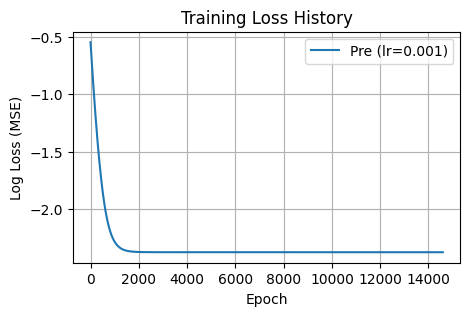

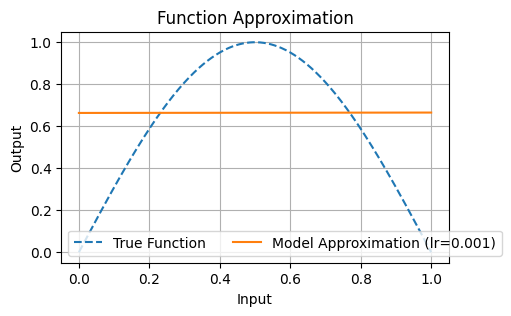

KeyboardInterrupt: 

In [ ]:
from tqdm.auto import tqdm

if __name__ == "__main__":
    # Configuration
    target = u2
    lr_grid = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
    width = 40
    m = 500
    max = 30000
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_seed = 42
    # Preconditioner
    T = create_cube_matrix_torch(width, device=device)
    I = torch.eye(width, device=device)

    preconditioner = I  ##################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# ------------------ DATA (fixed across LRs) ------------------ #
    rng = np.random.default_rng(seed=42)
    X_np = np.random.uniform(0, 1, m)
    y_np = target(X_np)
    X = torch.tensor(X_np, dtype=torch.float32, device=device)
    y = torch.tensor(y_np, dtype=torch.float32, device=device)


    X_test = torch.linspace(0, 1, 500, device=device).unsqueeze(1)
    y_true = target(X_test.cpu().numpy())
# ------------------------------------------------------------- #
    def make_net():
        return PreconditionedNetwork(
            width = width,
            activation= relu_cube,
            init_method='kaiming',
            device=device
        )

    all_loss_histories = []
    all_final_pred = []

    # Sweep ---------------------------------------------------- #
    for i, lr in enumerate(tqdm(lr_grid, desc = "Pre/no-pre only")):
        seed = base_seed
        net_i = make_net()

        loss_history_i = net_i.train(X, y, preconditioner, lr=lr, max_iter=max, tol=1e-6)
        all_loss_histories.append((float(lr), np.asarray(loss_history_i, dtype=float)))

        # Plot Loss Curve
        plt.figure(figsize=(5, 3))
        plt.plot(np.log(loss_history_i), label=f'Pre (lr={lr:.3g})')
        plt.xlabel('Epoch')
        plt.ylabel('Log Loss (MSE)')
        plt.title('Training Loss History')
        plt.legend()
        plt.grid(True)

        # Plot approximation
        with torch.no_grad():
            y_pred = net_i.forward(X_test, net_i.theta, preconditioner).cpu().numpy()
        all_final_pred.append((float(lr), y_pred))

        plt.figure(figsize=(5, 3))
        X_test_cpu = X_test.cpu().numpy()
        plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
        plt.plot(X_test_cpu, y_pred, label=f'Model Approximation (lr={lr:.3g})')
        plt.xlabel('Input')
        plt.ylabel('Output')
        plt.title('Function Approximation')
        plt.legend(ncol=2)
        plt.grid(True)
        plt.show()

# -------- overall ---------------------------------------------------- #
figA = plt.figure(figsize=(5, 3))
for lr, hist in all_loss_histories:
    plt.plot(np.log(hist), label=f'Pre (lr={lr:.3g})')
plt.xlabel('Epoch')
plt.ylabel('Log Loss (MSE)')
plt.title('Training Loss History Cross LRs')
plt.legend()
plt.grid(True)
plt.show()


figB = plt.figure(figsize=(5, 3))
X_test_cpu = X_test.cpu().numpy()
plt.plot(X_test_cpu, y_true, label='True Function', linestyle='--')
for lr, pred in all_final_pred:
    plt.plot(X_test_cpu, pred, label=f'(lr={lr:.3g})')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Function Approximation Cross LRs')
plt.legend(ncol=2)
plt.grid(True)
plt.show()








# PINN with SHALLOW NN

## Model for PINN

In [ ]:
# Helper Functions
def second_derivative(u, x):
    g1 = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    g2 = torch.autograd.grad(g1, x, grad_outputs=torch.ones_like(g1), create_graph=True, retain_graph=True)[0]
    return g2



def plot_solution(solution, model, theta, device="cuda", num_points: int = 500):
    X = torch.linspace(0.0, 1.0, num_points, device=device).unsqueeze(1)
    X_cpu = X.cpu().numpy()
    with torch.no_grad():
        u_hat = model.forward(X, theta).cpu().numpy()

    u_true = solution(X).cpu().numpy() # analytical solution

    plt.figure(figsize=(5, 3))
    plt.plot(X_cpu, u_true, "k--", label="Analytical u(x)=x")
    plt.plot(X_cpu, u_hat, label="PINN prediction")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# --------------- PINN Model Class --------------- #

# Modified PreconditionedNetwork class with visualization support
class PreconditionedPINNNetwork:
    def __init__(self, T, width, RHS_u,
                 left=0, right=1, activation=relu_cube,
                 init_method='ones', device='cuda'):
        self.T = T
        self.width = width
        self.activation = activation
        self.device = device
        self.RHS_u = RHS_u

        if init_method == 'ones':
            self.theta = init_params_ones(
                width, left, right, device
            )
        elif init_method == 'kaiming':
            self.theta = init_params_kaiming(
                width, device
            )
        else:
            raise ValueError("Invalid initialization method.")

    def unflatten_params(self, theta):
        sizes = [
            self.width,  # W1
            self.width,                  # b1
            self.width, # W2
            1,
        ]
        params = []
        ptr = 0
        for size in sizes:
            params.append(theta[ptr:ptr+size])
            ptr += size

        W1 = params[0]
        b1 = params[1]
        W2 = params[2]
        b2 = params[3]

        return W1, b1, W2, b2

    def forward(self, X, theta):
        W1, b1, W2, b2 = self.unflatten_params(theta)

        Z1 = X.unsqueeze(1) @ W1.unsqueeze(0) + b1
        # print((X.unsqueeze(1) @ W1.unsqueeze(0)).shape)
        # print(Z1.shape)
        A1 = self.activation(Z1)
        # print(A1.shape)
        A1_pre = A1 @ self.T.T
        # print(A1_pre.shape)

        Z2 = A1_pre @ W2 + b2

        # print('X.shape', str(X.shape))
        # print('W1.shape', str(W1.shape))
        # print('b1.shape', str(b1.shape))
        # print('Z1.shape', str(Z1.shape))
        # print('A1.shape', str(A1.shape))
        # print('A1_pre.shape', str(A1_pre.shape))
        # print('W2.shape', str(W2.shape))
        # print('b2.shape', str(b2.shape))
        # print('Z2.shape', str(Z2.shape))

        return Z2  #one-d shape

    # =============== PINN specifics =================== #
    def second_derivative(self, X_f: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
        """Compute second derivative uₓₓ for the collocation points X_f."""
        X_f = X_f.clone().detach().requires_grad_(True)
        u = self.forward(X_f, theta)
        # du = torch.autograd.grad(
        #     u,
        #     X_f,
        #     grad_outputs=torch.ones_like(u),
        #     retain_graph=True,
        #     create_graph=True,
        # )[0]
        # d2u = torch.autograd.grad(
        #     du,
        #     X_f,
        #     grad_outputs=torch.ones_like(du),
        #     retain_graph=True,
        #     create_graph=True,
        # )[0]
        d2u = second_derivative(u, X_f)
        return d2u

    def pinn_loss(
        self,
        X_f: torch.Tensor,
        X_b: torch.Tensor,
        y_b: torch.Tensor,
        theta: torch.Tensor,
        lambda_bc: float = 1.0,
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        r = self.second_derivative(X_f, theta)
        RHS = self.RHS_u(X_f)
        pde_loss = torch.mean((r - RHS) ** 2)
        bc_pred = self.forward(X_b, theta)
        bc_loss = torch.mean((bc_pred - y_b) ** 2)
        total = pde_loss + lambda_bc * bc_loss
        return total, pde_loss.detach(), bc_loss.detach()


    def PINN_train(self, X_f, X_b, y_b, lr=0.01, max_iter=1000, tol=1e-7, print_every = 1000):
        theta = self.theta

        # T = T.to(self.device) if isinstance(T, torch.Tensor) else torch.tensor(T, device=self.device
        # try:
        #     T_inv = torch.linalg.inv(T.float())
        # except:
        #     T += 1e-6 * torch.eye(T.size(0), device=self.device)
        #     T_inv = torch.linalg.inv(T.float())

        theta = self.theta
        number_of_params = len(theta)
        device = self.device

        loss_history = []
        prev_theta = theta.clone().detach()

        for i in range(max_iter):
            if theta.grad is not None:
                theta.grad.zero_()

            loss, pde_l, bc_l = self.pinn_loss(X_f, X_b, y_b, theta, lambda_bc=1.0)
            loss_history.append(loss.item())

            loss.backward()
            g = theta.grad

            with torch.no_grad():
                theta -= lr * g

            if torch.norm(theta - prev_theta) < tol:
                self.theta = theta.detach().requires_grad_(True)
                break
            prev_theta = theta.clone().detach()

            if (i + 1) % print_every == 0:
                print(
                    f"Epoch {i+1:>6} | total {loss.item():.3e} | PDE {pde_l.item():.3e} | BC {bc_l.item():.3e}"
                )

        self.theta = theta.detach().requires_grad_(True)
        return loss_history

## Equations and solutions

In [ ]:
import torch, math

def zero_constant(x):
  return 0
def answer_zero_constant(x):
  return x

# -------------------------------------------------------------------------------------------------------------------
# --- Set Dirichlet BCs for Case A ---
bc0 = 0.0   # u(0) = 0
bc1 = 0.0   # u(1) = 0

# --- RHS: f(x) = sin(pi x) + 0.5 sin(3 pi x) ---

def caseA(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(math.pi * x) + 0.5 * torch.sin(3.0 * math.pi * x)

# --- Exact solution for checking: u(x) = -sin(pi x)/pi^2 - sin(3 pi x)/(18 pi^2) ---
def solution_caseA(x: torch.Tensor) -> torch.Tensor:
    return -(torch.sin(math.pi * x)) / (math.pi**2) - (torch.sin(3.0 * math.pi * x)) / (18.0 * (math.pi**2))

# -------------------------------------------------------------------------------------------------------------------
# Dirichlet BCs for Case B
bc0 = 0.0
bc1 = 0.0

# RHS: f(x) = e^x
def caseB(x: torch.Tensor) -> torch.Tensor:
    return torch.exp(x)

# Exact solution for checking:
# u(x) = e^x + (1 - e) x - 1
def solution_caseB(x: torch.Tensor) -> torch.Tensor:
    return torch.exp(x) + (1.0 - math.e) * x - 1.0




In [ ]:
device = 'cuda'
fig = plt.figure(figsize=(5, 3))
X = torch.linspace(0.0, 1.0, 500, device=device).unsqueeze(1)
X_cpu = X.cpu().numpy()
u_true_A = solution_caseA(X).cpu().numpy() # analytical solution
u_true_B = solution_caseB(X).cpu().numpy() # analytical solution
plt.plot(X_cpu, u_true_A, "k", label="Analytical A")
plt.plot(X_cpu, u_true_B, "k--", label="Analytical B")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()

AssertionError: Torch not compiled with CUDA enabled

<Figure size 500x300 with 0 Axes>

## Solving

Epoch   1000 | total 6.564e-02 | PDE 6.564e-02 | BC 1.701e-08
Epoch   2000 | total 6.308e-02 | PDE 6.308e-02 | BC 6.083e-07
Epoch   3000 | total 4.789e-02 | PDE 4.789e-02 | BC 1.322e-06
Epoch   4000 | total 4.552e-02 | PDE 4.552e-02 | BC 3.497e-09
Epoch   5000 | total 4.521e-02 | PDE 4.521e-02 | BC 6.836e-09
Epoch   6000 | total 4.345e-02 | PDE 4.345e-02 | BC 5.410e-07
Epoch   7000 | total 3.752e-02 | PDE 3.752e-02 | BC 3.315e-06
Epoch   8000 | total 3.807e-02 | PDE 3.804e-02 | BC 2.735e-05
Epoch   9000 | total 3.771e-02 | PDE 3.769e-02 | BC 2.198e-05
Epoch  10000 | total 3.749e-02 | PDE 3.747e-02 | BC 1.756e-05


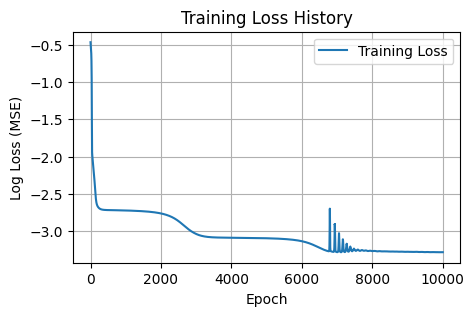

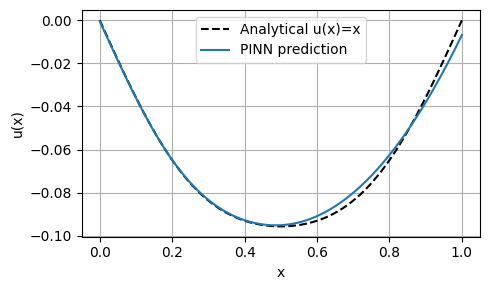

In [ ]:
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Configuration
    RHS = caseA
    lr = 0.01
    width = 40
    # m = 500
    max = 10000
    activation = relu_cube
    starting_point = 'kaiming'
    T = create_cube_matrix_torch(width, device=device)
    I = torch.eye(width, device=device)
    preconditioner = T
    N_f = 1000

    # Build Network
    model = PreconditionedPINNNetwork(
        T = preconditioner,
        width = width,
        RHS_u = RHS,
        activation= activation,
        init_method=starting_point,
        device=device
    )

    # Collection of Data
    X_f = torch.rand(N_f, device=device)

    X_b = torch.tensor([[0.0], [1.0]], device=device)
    y_b = torch.tensor([[0.0], [0.0]], device=device)    ################## Boundary Condition


    # TRAIN
    history = model.PINN_train(X_f, X_b, y_b, lr, max, tol = 1e-7, print_every = 1000)

    plot_training_log_loss(history)
    plot_solution(solution_caseA, model, model.theta, device, num_points=500)

## The LOOPs

Pre/no-pre only:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch   1000 | total 2.516e-02 | PDE 4.685e-03 | BC 2.047e-02
Epoch   2000 | total 2.732e-03 | PDE 2.655e-03 | BC 7.628e-05
Epoch   3000 | total 2.418e-03 | PDE 2.418e-03 | BC 3.877e-07
Epoch   4000 | total 2.284e-03 | PDE 2.284e-03 | BC 2.321e-07
Epoch   5000 | total 2.174e-03 | PDE 2.173e-03 | BC 8.165e-07
Epoch   6000 | total 2.079e-03 | PDE 2.078e-03 | BC 8.891e-07
Epoch   7000 | total 1.985e-03 | PDE 1.984e-03 | BC 1.429e-06
Epoch   8000 | total 1.889e-03 | PDE 1.887e-03 | BC 1.807e-06
Epoch   9000 | total 1.788e-03 | PDE 1.786e-03 | BC 2.361e-06
Epoch  10000 | total 1.681e-03 | PDE 1.678e-03 | BC 2.759e-06


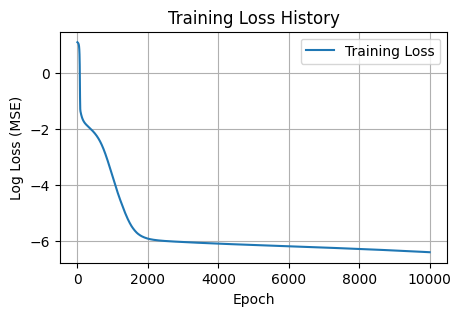

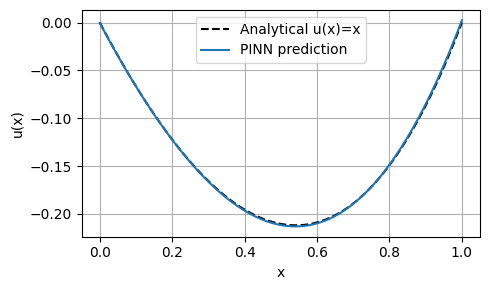

Epoch   1000 | total 2.730e-03 | PDE 2.725e-03 | BC 5.436e-06
Epoch   2000 | total 2.610e-03 | PDE 2.610e-03 | BC 2.356e-07
Epoch   3000 | total 2.500e-03 | PDE 2.499e-03 | BC 1.658e-07
Epoch   4000 | total 2.382e-03 | PDE 2.382e-03 | BC 1.002e-07
Epoch   5000 | total 2.246e-03 | PDE 2.246e-03 | BC 7.195e-08
Epoch   6000 | total 2.076e-03 | PDE 2.076e-03 | BC 4.914e-08
Epoch   7000 | total 1.854e-03 | PDE 1.854e-03 | BC 1.590e-07
Epoch   8000 | total 1.554e-03 | PDE 1.554e-03 | BC 1.160e-07
Epoch   9000 | total 1.187e-03 | PDE 1.187e-03 | BC 3.755e-07
Epoch  10000 | total 8.191e-04 | PDE 8.177e-04 | BC 1.400e-06


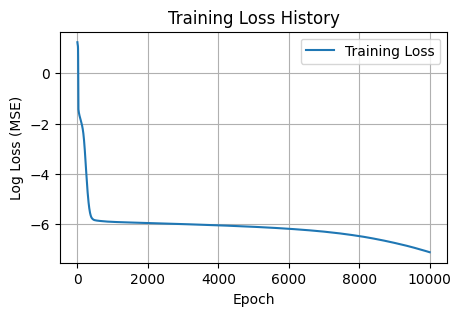

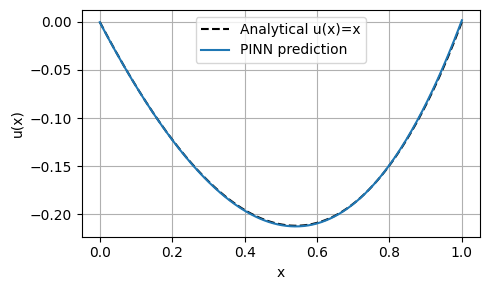

Epoch   1000 | total 2.550e-03 | PDE 2.550e-03 | BC 2.140e-07
Epoch   2000 | total 2.210e-03 | PDE 2.210e-03 | BC 6.455e-08
Epoch   3000 | total 1.579e-03 | PDE 1.578e-03 | BC 1.017e-06
Epoch   4000 | total 6.731e-04 | PDE 6.665e-04 | BC 6.550e-06
Epoch   5000 | total 3.143e-04 | PDE 3.101e-04 | BC 4.187e-06
Epoch   6000 | total 2.376e-04 | PDE 2.364e-04 | BC 1.184e-06
Epoch   7000 | total 2.067e-04 | PDE 2.064e-04 | BC 3.083e-07
Epoch   8000 | total 3.054e-03 | PDE 2.921e-03 | BC 1.330e-04
Epoch   9000 | total 9.188e-04 | PDE 8.788e-04 | BC 4.001e-05
Epoch  10000 | total 1.068e-03 | PDE 1.021e-03 | BC 4.734e-05


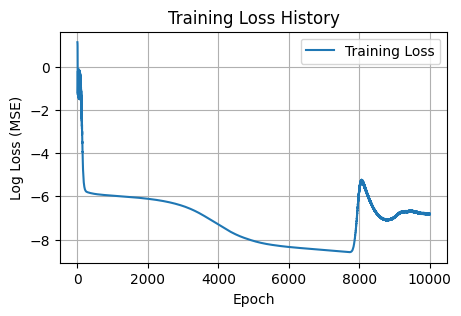

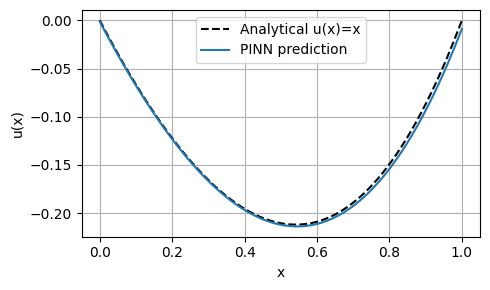

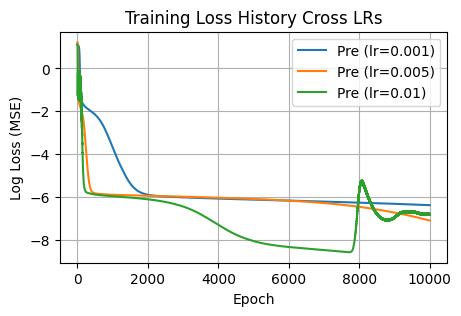

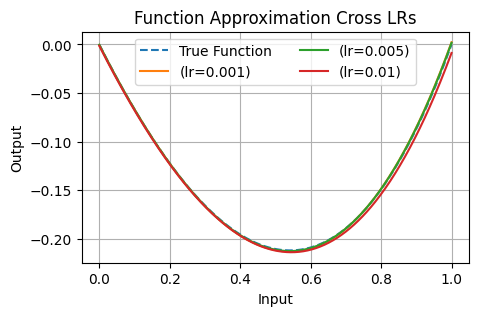

In [ ]:
from tqdm.auto import tqdm
import os, random, copy

if __name__ == "__main__":
    def set_seed(seed=42):
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # for CUDA determinism (if available)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(False)

    set_seed(42)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Configuration
    RHS = caseB
    solution = solution_caseB
    lr_grid = [1e-3, 5e-3, 1e-2]# , 5e-2] #1e-1]
    width = 40
    m = 500
    max = 10000
    activation = relu_cube
    starting_point = 'kaiming'
    T = create_cube_matrix_torch(width, device=device)
    I = torch.eye(width, device=device)
    preconditioner = T                                               #### !!!!!!!!!!!!!!!!!!!!!!!
    N_f = 1000
    # ------------------------------------------------------------- #
    def make_net():
        return PreconditionedPINNNetwork(
            T = preconditioner,
            width = width,
            RHS_u = RHS,
            activation= activation,
            init_method=starting_point,
            device=device
        )

    # ------------------------------------------------------------- #
    # Collection of Data
    # rng = np.random.default_rng(seed=42)

    X_f = torch.rand(N_f, device=device)

    X_b = torch.tensor([[0.0], [1.0]], device=device)
    y_b = torch.tensor([[0.0], [0.0]], device=device)    ################## Boundary Condition
    # ------------------------------------------------------------- #
    all_loss_histories = []
    all_final_pred = []

    for i, lr in enumerate(tqdm(lr_grid, desc = "Pre/no-pre only")):
        model_i = make_net()
        history_i = model_i.PINN_train(X_f, X_b, y_b, lr, max, tol = 1e-7, print_every = 1000)
        all_loss_histories.append((float(lr), np.asarray(history_i, dtype=float)))
        plot_training_log_loss(history_i)
        X_test = torch.linspace(0.0, 1.0, 500, device=device).unsqueeze(1)
        # Plot approximation
        with torch.no_grad():
            solution_i = model_i.forward(X_test, model_i.theta).cpu().numpy()
        all_final_pred.append((float(lr), solution_i))
        plot_solution(solution, model_i, model_i.theta, device, num_points=500)
        plt.show()
    # -------- overall ---------------------------------------------------- #
    figA = plt.figure(figsize=(5, 3))
    for lr, hist in all_loss_histories:
        plt.plot(np.log(hist), label=f'Pre (lr={lr:.3g})')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss (MSE)')
    plt.title('Training Loss History Cross LRs')
    plt.legend()
    plt.grid(True)
    plt.show()

    figB = plt.figure(figsize=(5, 3))
    X_test_cpu = X_test.cpu().numpy()
    solution_true = solution(X_test).cpu().numpy()
    plt.plot(X_test_cpu, solution_true, label='True Function', linestyle='--')
    for lr, pred in all_final_pred:
        plt.plot(X_test_cpu, pred, label=f'(lr={lr:.3g})')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Function Approximation Cross LRs')
    plt.legend(ncol=2)
    plt.grid(True)
    plt.show()


## compare

Epoch   1000 | total 3.466e-03 | PDE 3.466e-03 | BC 3.850e-10
Epoch   2000 | total 1.700e-03 | PDE 1.700e-03 | BC 1.308e-08
Epoch   3000 | total 2.883e-04 | PDE 2.883e-04 | BC 3.188e-08
Epoch   4000 | total 2.247e-04 | PDE 2.247e-04 | BC 2.309e-10
Epoch   5000 | total 2.185e-04 | PDE 2.185e-04 | BC 4.453e-10
Epoch   6000 | total 2.179e-04 | PDE 2.179e-04 | BC 1.557e-10
Epoch   7000 | total 2.176e-04 | PDE 2.176e-04 | BC 8.609e-11
Epoch   8000 | total 2.174e-04 | PDE 2.174e-04 | BC 6.984e-11
Epoch   9000 | total 2.173e-04 | PDE 2.173e-04 | BC 6.816e-11
Epoch  10000 | total 2.172e-04 | PDE 2.172e-04 | BC 1.920e-11
Epoch  11000 | total 2.171e-04 | PDE 2.171e-04 | BC 7.047e-11
Epoch  12000 | total 2.170e-04 | PDE 2.170e-04 | BC 6.925e-11
Epoch  13000 | total 2.169e-04 | PDE 2.169e-04 | BC 7.059e-11
Epoch  14000 | total 2.168e-04 | PDE 2.168e-04 | BC 6.651e-11
Epoch  15000 | total 2.167e-04 | PDE 2.167e-04 | BC 6.833e-11
Epoch   1000 | total 6.680e-03 | PDE 4.136e-03 | BC 2.545e-03
Epoch   

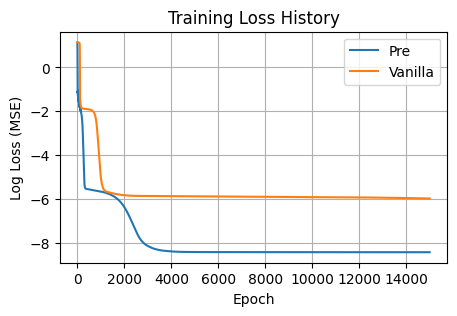

Pre_lr = 0.01
Vanilla_lr = 0.01


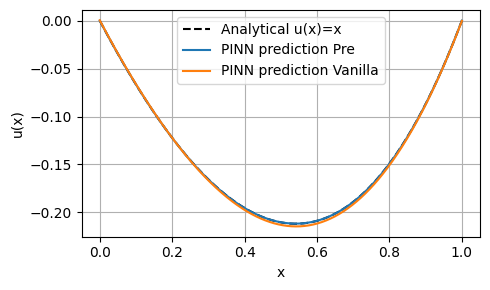

In [ ]:
import os, random, copy

if __name__ == "__main__":

    def set_seed(seed=42):
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # for CUDA determinism (if available)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(False)

    set_seed(42)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Configuration
    RHS = caseB
    lr_Pre = 0.01
    lr_Vanilla = 0.01
    width = 40
    m = 500
    max = 15000
    activation = relu_cube
    starting_point = 'kaiming'
    T = create_cube_matrix_torch(width, device=device)
    I = torch.eye(width, device=device)
    preconditioner = T
    N_f = 1000

    # Build Network Pre
    model_pre = PreconditionedPINNNetwork(
        T = T,
        width = width,
        RHS_u = RHS,
        activation= activation,
        init_method=starting_point,
        device=device
    )

    # Build Network Vanilla
    model_vanilla = PreconditionedPINNNetwork(
        T = I,
        width = width,
        RHS_u = RHS,
        activation= activation,
        init_method=starting_point,
        device=device
    )


    # Collection of Data
    # rng = np.random.default_rng(seed=42)

    X_f = torch.rand(N_f, device=device)

    X_b = torch.tensor([[0.0], [1.0]], device=device)
    y_b = torch.tensor([[0.0], [0.0]], device=device)    ################## Boundary Condition


    # TRAIN
    history_pre = model_pre.PINN_train(X_f, X_b, y_b, lr_Pre, max, tol = 1e-7, print_every = 1000)
    history_vanilla = model_vanilla.PINN_train(X_f, X_b, y_b, lr_Vanilla, max, tol = 1e-7, print_every = 1000)

    #plot in one
    plt.figure(figsize=(5, 3))
    plt.plot(np.log(history_pre), label=f'Pre')
    plt.plot(np.log(history_vanilla), label=f'Vanilla')
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss (MSE)')
    plt.title('Training Loss History')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(5, 3))
    X = torch.linspace(0.0, 1.0, 500, device=device).unsqueeze(1)
    with torch.no_grad():
        u_hat_pre = model_pre.forward(X, model_pre.theta).cpu().numpy()
        u_hat_vanilla = model_vanilla.forward(X, model_vanilla.theta).cpu().numpy()
    X_cpu = X.cpu().numpy()
    u_true = solution_caseB(X).cpu().numpy()  # analytical solution for BC u(0)=0, u(1)=1
    plt.plot(X_cpu, u_true, "k--", label="Analytical u(x)=x")
    plt.plot(X_cpu, u_hat_pre, label="PINN prediction Pre")
    plt.plot(X_cpu, u_hat_vanilla, label="PINN prediction Vanilla")
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    print('Pre_lr =', lr_Pre)
    print('Vanilla_lr =', lr_Vanilla)
    plt.show()